In [1]:
import numpy as np;
from visualize import plot_2, plot_3, plot_3d, plot_6;
from load_dataset import load_yale;
from conduct_svm import svm;
from conduct_csc import nn_csc, csc, par_csc, par_nn_csc;
from pickless import output;
from pooling import forward;
from sporco import plot, util;
from conduct_svm import *;
from torch.nn.modules.pooling import MaxPool2d, MaxUnpool2d;
import torch;

In [2]:
def make_option():
    opt = {};
    # 画像のサイズ
    opt["height"] = 48; # original: 192
    opt["width"] = 42; # original: 168
    # 訓練画像の枚数
    opt['train_amount'] = 32;
    # テスト画像の枚数
    opt['test_amount'] = 32;
    # フィルタのサイズ
    opt['d_size'] = [(8, 8, 1, 1, 16), (4, 4, 16, 16)];
    # スパースの尺度
    opt['lmbda'] = [0.05, 0.002];
    # 繰り返し回数
    opt['Iter'] = [400, 400];
    # NMFによる錐制約部分空間法における基底の数
    opt['d_num'] = 16;
    # PCAによる包括凸錐による部分空間法における累積寄与率のリスト・パラメータ
    opt["ratios"] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9];
    opt["params"] = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5];
    return opt;

In [3]:
opt = make_option();
train_data, train_label, test_data, test_label = load_yale(opt["train_amount"], opt["test_amount"], opt["height"], opt["width"]);
"""
npd = 16
fltlmbd = 5
sl, sh = util.tikhonov_filter(train_data, fltlmbd, npd);
t_sl, t_sh = util.tikhonov_filter(test_data, fltlmbd, npd);
"""

'\nnpd = 16\nfltlmbd = 5\nsl, sh = util.tikhonov_filter(train_data, fltlmbd, npd);\nt_sl, t_sh = util.tikhonov_filter(test_data, fltlmbd, npd);\n'

In [6]:
train_data[:, :, 0]

array([[-81.51326885, -82.51326885, -77.26326885, ..., -80.51326885,
        -79.76326885, -78.26326885],
       [-82.51326885, -83.01326885, -76.51326885, ..., -82.76326885,
        -82.26326885, -82.51326885],
       [-78.76326885, -80.51326885, -70.51326885, ..., -83.01326885,
        -83.51326885, -83.51326885],
       ...,
       [-74.76326885, -78.26326885, -81.76326885, ..., -31.51326885,
        -71.01326885, -77.26326885],
       [-76.76326885, -74.51326885, -80.51326885, ..., -51.26326885,
        -69.01326885, -72.51326885],
       [-73.01326885, -73.26326885, -77.01326885, ..., -58.26326885,
        -66.01326885, -75.26326885]])

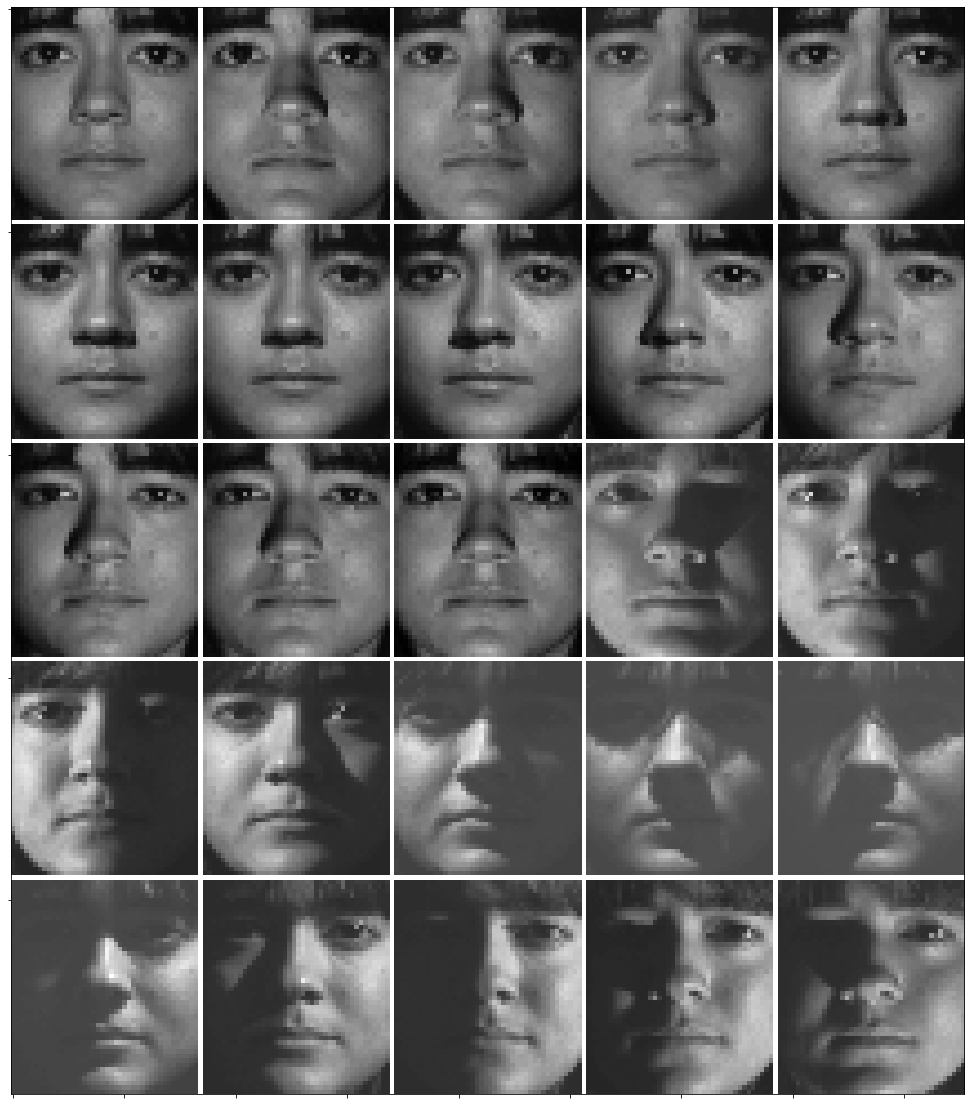

In [7]:
fig = plot.figure(figsize = (20, 20));
plot.imview(util.tiledict(train_data[:, :, 0:25]), fig = fig);

In [ ]:
# 学習用データセットで辞書学習

print("### 学習用データセットで畳み込み辞書学習");

print("第１層目:フォワードパスの計算中...");
d0, D0, coef0_ = nn_csc(input_ = train_data, d_size = opt['d_size'][0], lmbda = opt['lmbda'][0], Iter = opt['Iter'][0], visualize = True);
print(coef0_.shape)
print("第１層目:プーリング中...");
pool0 = MaxPool2d(2, stride = 2, return_indices = True);
pooled0, index0 = pool0(torch.from_numpy(coef0_.squeeze().transpose(2,3,0,1)));
coef0 = pooled0.cpu().numpy().transpose(2,3,1,0);
print(pooled0.shape)
del pool0, pooled0, coef0_;
# coef0 = forward(coef0_.squeeze().transpose(2,3,0,1), 2, 2, 2).transpose(1,2,3,0);

### 学習用データセットで畳み込み辞書学習
第１層目:フォワードパスの計算中...
Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  2.75e+08  2.73e+08  4.50e+07  6.40e-16  7.07e-01  1.01e+00  3.00e+00  3.20e-01  1.43e-01  1.00e+01
   1  2.82e+08  2.78e+08  8.26e+07  6.60e-16  2.95e-01  2.13e+00  3.00e+00  3.24e-01  2.47e-01  1.00e+01
   2  4.20e+07  3.68e+07  1.03e+08  6.14e-16  1.30e-01  3.42e+00  3.00e+00  2.48e-01  2.39e-01  1.00e+01
   3  1.27e+07  7.39e+06  1.05e+08  6.70e-16  6.64e-02  3.26e+00  3.00e+00  1.72e-01  1.41e-01  1.00e+01
   4  7.89e+06  2.55e+06  1.07e+08  6.69e-16  3.09e-02  3.13e+00  3.00e+00  1.44e-01  1.42e-01  1.00e+01
   5  6.05e+06  6.85e+05  1.07e+08  5.63e-16  1.83e-02  3.15e+00  3.00e+00  1.16e-01  1.14e-01  1.00e+01
   6  5.75e+06  3.72e+05  1.07e+08  7.01e-16  1.03e-02  1.78e+00  3.00e+00  9.69e-02  9.88e-02  1.00e+01


In [6]:
print("第２層目:フォワードパスの計算中...");
d1, D1, coef1_ = nn_csc(input_ = coef0, d_size = opt['d_size'][1], lmbda = opt['lmbda'][1], Iter = opt['Iter'][1], visualize = False);
print("第２層目:プーリング中...");
pool1 = MaxPool2d(2, stride = 2, return_indices = True);
pooled1, index1 = pool1(torch.from_numpy(coef1_.squeeze().transpose(2,3,0,1)));
coef1 = pooled1.cpu().numpy().transpose(2,3,1,0);
del pool1, pooled1, coef1_;

第２層目:フォワードパスの計算中...
Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D     
--------------------------------------------------------------------------------------------------------
   0  4.02e+07  4.02e+07  3.24e+06  1.12e-15  7.11e-01  1.00e+00  6.00e-01  3.20e-01  2.45e-01  1.00e+01
   1  3.46e+07  3.46e+07  5.85e+06  1.43e-15  2.65e-01  1.53e+00  6.00e-01  2.85e-01  2.80e-01  1.00e+01
   2  2.18e+07  2.17e+07  8.28e+06  9.95e-16  1.41e-01  1.41e+00  6.00e-01  3.10e-01  2.79e-01  1.00e+01
   3  1.64e+07  1.64e+07  9.66e+06  1.08e-15  8.82e-02  1.55e+00  6.00e-01  2.62e-01  2.06e-01  1.00e+01
   4  1.46e+07  1.46e+07  1.03e+07  1.44e-15  5.40e-02  1.78e+00  6.00e-01  2.47e-01  1.81e-01  1.00e+01
   5  1.41e+07  1.41e+07  1.06e+07  1.21e-15  3.62e-02  2.16e+00  6.00e-01  2.06e-01  1.31e-01  1.00e+01
   6  1.40e+07  1.39e+07  1.08e+07  1.33e-15  2.52e-02  2.19e+00  6.00e-01  1.81e-01  1.10e-01  1.00e+01
   7  1.38e+07  1.38e+07  1.09e+07 

In [13]:
d1.reconstruct().squeeze().shape

(48, 42, 6, 200)

(48, 42, 16, 100)


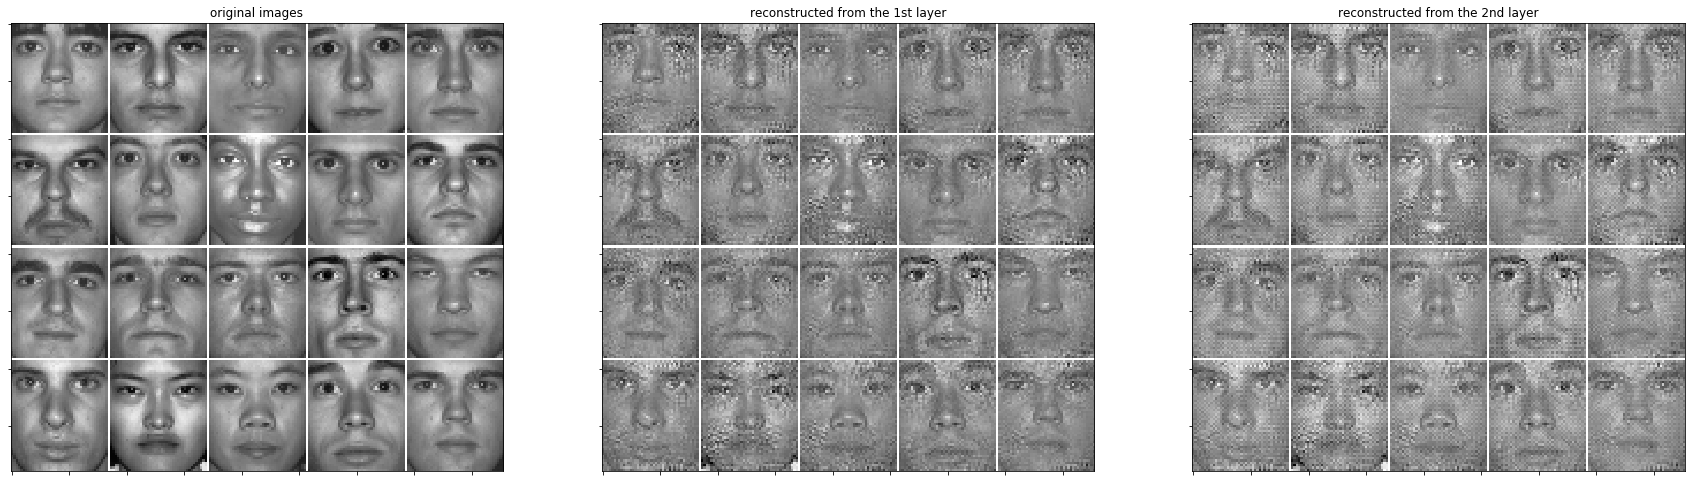

In [7]:
# unpooling
unpool = MaxUnpool2d(2, stride = 2);
unpooled = unpool(torch.from_numpy(coef0.squeeze().transpose(3, 2, 0, 1)), index0);
unpooled = unpooled.cpu().numpy().transpose(2, 3, 1, 0);
from_first = d0.reconstruct(X = np.expand_dims(unpooled.transpose(0, 1, 3, 2), 2)).squeeze();

# unpooling
unpool = MaxUnpool2d(2, stride = 2);
unpooled = unpool(torch.from_numpy(d1.reconstruct().squeeze().transpose(3, 2, 0, 1)), index0);
unpooled = unpooled.cpu().numpy().transpose(2, 3, 1, 0);
print(unpooled.shape)
from_second = d0.reconstruct(X=np.expand_dims(unpooled.transpose(0, 1, 3, 2), 2)).squeeze();

fig = plot.figure(figsize = (30, 10));

ax0 = fig.add_subplot(131);
ax1 = fig.add_subplot(132);
ax2 = fig.add_subplot(133);

plot.imview(util.tiledict(train_data[:, :, 0:125:5]), fig = fig, ax = ax0, title = "original images");
plot.imview(util.tiledict(from_first[:, :, 0:125:5]), fig = fig, ax = ax1, title = "reconstructed from the 1st layer");
plot.imview(util.tiledict(from_second[:, :, 0:125:5]), fig = fig, ax = ax2, title = "reconstructed from the 2nd layer");


In [8]:
train_coef = coef1.transpose(3, 0, 1, 2).reshape(opt["train_amount"]*20, -1);
np.save("./coefficients_yale/train_feature.npy", train_coef);

In [9]:
t_sh.shape

NameError: name 't_sh' is not defined

In [9]:
from sporco.admm import cbpdn
from sporco.cupy import np2cp, cp2np;
# テスト用データセットの係数算出
print("### テスト用データセットの係数算出 ###");

test_opt0 = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': opt["Iter"][0], 'RelStopTol': 5e-3, 'AuxVarObj': False, 'NonNegCoef':True});
b0 = cbpdn.ConvBPDN(D0.squeeze(), test_data, opt["lmbda"][0], test_opt0);
print("第１層目:フォワードパスの計算中...");
test_coef0 = b0.solve();
print("第１層目:プーリング中...");
t_pool0 = MaxPool2d(2, stride = 2, return_indices = True);
t_pooled0, t_index0 = t_pool0(torch.from_numpy(test_coef0.squeeze().transpose(2,3,0,1)));
test_coef0 = t_pooled0.cpu().numpy().transpose(2,3,1,0);
del t_pool0, t_pooled0;


test_opt1 = cbpdn.ConvBPDN.Options({'Verbose': True, 'MaxMainIter': opt["Iter"][1], 'RelStopTol': 5e-3, 'AuxVarObj': False, 'NonNegCoef':True});
test_coef0 = np.expand_dims(test_coef0, -1);
b1 = cbpdn.ConvBPDN(D1.squeeze(), test_coef0, opt["lmbda"][1], test_opt1);
print("第２層目:フォワードパスの計算中...");
test_coef1 = b1.solve();
print("第２層目:プーリング中...");
t_pool1 = MaxPool2d(2, stride = 2, return_indices = True);
t_pooled1, t_index1 = t_pool1(torch.from_numpy(test_coef1.squeeze().transpose(2,3,0,1)));
test_coef1 = t_pooled1.cpu().numpy().transpose(2,3,1,0);
del t_pool1, t_pooled1;

### テスト用データセットの係数算出 ###
第１層目:フォワードパスの計算中...
Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  4.70e+08  4.67e+08  6.50e+07  7.08e-01  1.01e+00  3.50e+00
   1  4.75e+08  4.69e+08  1.17e+08  3.10e-01  3.64e+00  3.50e+00
   2  3.40e+07  2.50e+07  1.80e+08  2.46e-01  3.58e+00  8.58e-01
   3  1.21e+07  6.90e+05  2.28e+08  2.17e-01  4.55e+00  1.89e-01
   4  1.14e+07  1.20e+04  2.28e+08  1.97e-01  2.85e+00  3.47e-02
   5  1.14e+07  5.01e+03  2.28e+08  4.58e-01  1.06e+00  7.66e-03
   6  1.25e+07  5.83e+03  2.49e+08  6.66e-01  3.97e-01  4.22e-03
   7  1.07e+07  8.23e+03  2.14e+08  5.42e-01  3.07e-01  4.22e-03
   8  9.31e+06  8.49e+03  1.86e+08  3.53e-01  3.29e-01  4.71e-03
   9  9.23e+06  6.84e+03  1.84e+08  3.13e-01  2.63e-01  4.11e-03
  10  7.85e+06  6.00e+03  1.57e+08  2.71e-01  3.09e-01  4.11e-03
  11  7.55e+06  6.29e+03  1.51e+08  2.99e-01  2.15e-01  3.23e-03
  12  6.81e+06  7.06e+03  1.36e+08  2.43e-01  

^C
failed

CondaError: KeyboardInterrupt



In [10]:
test_feature = test_coef1.transpose(3, 0, 1, 2).reshape(opt["test_amount"]*20, -1);
print("test_feature:", test_feature.shape);
np.save("./coefficients_yale/test_feature.npy", test_feature);

test_feature: (1180, 1920)


In [11]:
# SVMによる分類
clf = train_svm(train_coef, train_label);
test_precision = test_svm(clf, test_feature, test_label);

Train precision:  1.0
Test precision:  0.05


In [12]:
from sklearn.metrics.pairwise import cosine_similarity;
# 錘を作るための関数郡
from sklearn.decomposition import NMF
def create_cone_NMF(feature, num):
    nmf = NMF(n_components=num);
    W = nmf.fit_transform(feature);
    H = nmf.components_;
    return nmf, H, W;

def restore_from_cone_NMF(feature, nmf):
    restore = nmf.inverse_transform(nmf.transform(feature));
    return restore;

def NMF_Classifier(train_feature, train_label, test_feature, test_label, from_, to_, class_num):
    accuracy = []
    for h in range(from_, to_+1):
        NMFs = [];
        Hs = [];
        Ws = [];
        for i in range(class_num):
            #print(str(i)+"番目のクラスの錐を作成中...");
            nmf, H, W = create_cone_NMF(train_feature[train_label == i], h);
            NMFs.append(nmf);
            Hs.append(H);
            Ws.append(W);
        restores = [];
        for i in range(class_num):
            #print(str(i)+"番目のクラスの錐で入力を再現中...")
            temp = restore_from_cone_NMF(test_feature, NMFs[i]);
            restores.append(temp);
        CosArray = [];
        for i in range(class_num):
            cos_array = cosine_similarity(test_feature, restores[i]);
            CosArray.append(np.diag(cos_array));            
        CosArray = np.array(CosArray);
        predict_label = np.argmax(CosArray, axis = 0);
        precision = sum(predict_label == test_label)/test_label.shape[0];
        accuracy.append(precision);
        print("d_num="+str(h)+": Test precision: ", precision);
    fig = plot.figure();
    ax = fig.add_subplot(111);
    ax.set_xlabel("# of basis");
    ax.set_ylabel("Accuracy");
    ax.set_ylim(0.8, 1.0);
    ax.plot(accuracy);
    ax.set_title("Cone restricted subspace method by NMF");
    fig.savefig("result/nmf_yale.png")

d_num=1: Test precision:  0.15254237288135594
d_num=2: Test precision:  0.211864406779661
d_num=3: Test precision:  0.2669491525423729
d_num=4: Test precision:  0.27372881355932205
d_num=5: Test precision:  0.2711864406779661
d_num=6: Test precision:  0.2754237288135593
d_num=7: Test precision:  0.29067796610169494
d_num=8: Test precision:  0.29152542372881357
d_num=9: Test precision:  0.29745762711864404
d_num=10: Test precision:  0.29745762711864404
d_num=11: Test precision:  0.29745762711864404
d_num=12: Test precision:  0.2940677966101695
d_num=13: Test precision:  0.30338983050847457
d_num=14: Test precision:  0.3
d_num=15: Test precision:  0.31186440677966104
d_num=16: Test precision:  0.3059322033898305


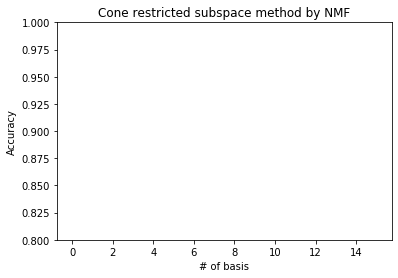

In [13]:
NMF_Classifier(train_coef, train_label, test_feature, test_label, 1, 16, 20);

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from scipy.optimize import nnls;

def create_cone_PCA(feature, param, ratio):
    feature = normalize(feature);
    pca = PCA(n_components=ratio);
    pca.fit(feature);
    variance = pca.explained_variance_;
    mean = pca.mean_;
    basis = pca.components_;
    cone_basis = [];
    cnt = 0;
    for i in variance:
        cone_basis.append(mean+param*np.sqrt(i)*basis[cnt]);
        cone_basis.append(mean-param*np.sqrt(i)*basis[cnt]);
        cnt=cnt+1;
    cone_basis = np.array(cone_basis);
    return cone_basis;

def restore_from_cone_PCA(cone_basis, feature):
    feature = list(feature);
    restore = [];
    for i in feature:
        x = np.array(nnls(cone_basis.T, i)[0]);
        restore.append(cone_basis.T.dot(x));
    restore = np.array(restore);
    return restore;

from matplotlib import pyplot as plt
def PCA_Classifier(train_feature, train_label, test_feature, test_label, params, ratios, class_num):
    fig = plot.figure();
    ax = fig.add_subplot(111);
    cmap = plt.get_cmap("tab10");
    ax.set_title("Cone restricted subspace method by Comprehensive cone");
    ax.set_xlabel("ratios");
    ax.set_ylabel("Accuracy");
    ax.set_ylim(0.8, 1.0);
    cnt=0;
    for param in params:
        accuracy = [];
        print("the parameter of scaling : "+str(param))
        for ratio in ratios:
            Cones = [];

            for i in range(class_num):
                #print(str(i)+"番目のクラスの錐を作成中...");
                cone = create_cone_PCA(train_feature[train_label == i], param, ratio);
                Cones.append(cone);
            restores = [];
            for i in range(class_num):
                #print(str(i)+"番目のクラスの錐で入力を再現中...")
                temp = restore_from_cone_PCA(Cones[i], test_feature);
                restores.append(temp);
            CosArray = [];
            for i in range(class_num):
                cos_array = cosine_similarity(test_feature, restores[i]);
                CosArray.append(np.diag(cos_array));

            CosArray = np.array(CosArray);
            predict_label = np.argmax(CosArray, axis = 0);
            precision = sum(predict_label == test_label)/test_label.shape[0];
            print("ratio="+str(ratio)+": Test precision: ", precision);
            accuracy.append(precision);
        ax.plot(accuracy, label = "k="+str(param), color = cmap(cnt));
        cnt=cnt+1;
    ax.legend();
    fig.savefig("result/Comprehensive_yale.png");

the parameter of scaling : 0.5
ratio=0.1: Test precision:  0.2
ratio=0.2: Test precision:  0.2
ratio=0.3: Test precision:  0.2
ratio=0.4: Test precision:  0.2
ratio=0.5: Test precision:  0.20254237288135593
ratio=0.6: Test precision:  0.2076271186440678
ratio=0.7: Test precision:  0.21016949152542372
ratio=0.8: Test precision:  0.21016949152542372
ratio=0.9: Test precision:  0.2093220338983051
the parameter of scaling : 1.0
ratio=0.1: Test precision:  0.21779661016949153
ratio=0.2: Test precision:  0.21779661016949153
ratio=0.3: Test precision:  0.21779661016949153
ratio=0.4: Test precision:  0.21779661016949153
ratio=0.5: Test precision:  0.22542372881355932
ratio=0.6: Test precision:  0.2347457627118644
ratio=0.7: Test precision:  0.24067796610169492
ratio=0.8: Test precision:  0.24067796610169492
ratio=0.9: Test precision:  0.24067796610169492
the parameter of scaling : 1.5
ratio=0.1: Test precision:  0.22796610169491524
ratio=0.2: Test precision:  0.22796610169491524
ratio=0.3: Tes

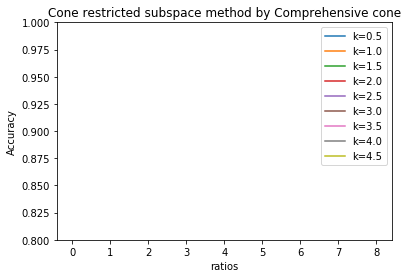

In [15]:
PCA_Classifier(train_coef, train_label, test_feature, test_label, opt["params"], opt["ratios"], 20);